In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

from sklearn.metrics import mean_squared_error

# Read in Data and see Basic Statistics

In [2]:
# data = pd.read_csv("data/train.csv")
train = pd.read_csv('data/train.csv',parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
data = pd.concat([train,test],sort=True)
data = data.drop("id", axis=1)
data = data.dropna()

In [3]:
data.head()

,date,item,sales,store
0,2013-01-01,1,13.0,1
1,2013-01-02,1,11.0,1
2,2013-01-03,1,14.0,1
3,2013-01-04,1,13.0,1
4,2013-01-05,1,10.0,1


In [4]:
data.tail()

,date,item,sales,store
912995,2017-12-27,50,63.0,10
912996,2017-12-28,50,59.0,10
912997,2017-12-29,50,74.0,10
912998,2017-12-30,50,62.0,10
912999,2017-12-31,50,82.0,10


In [5]:
data.describe()

,item,sales,store
count,913000.000000,913000.000000,913000.000000
mean,25.500000,52.250287,5.500000
std,14.430878,28.801144,2.872283
min,1.000000,0.000000,1.000000
25%,13.000000,30.000000,3.000000
50%,25.500000,47.000000,5.500000
75%,38.000000,70.000000,8.000000
max,50.000000,231.000000,10.000000


The data contains multiple stores and items per store, we will be focusing on only 1 store and 1 item for forecasting

In [6]:
#Reduce data to only item 1 in store 1
data = data[data["store"] == 1]
data = data[data["item"] == 1]

print("Number of rows is: " + str(len(data)))

Number of rows is: 1826


In [7]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.dayofyear
data['weekday'] = data['date'].dt.weekday

data.head()

,date,item,sales,store,year,month,day,weekday
0,2013-01-01,1,13.0,1,2013,1,1,1
1,2013-01-02,1,11.0,1,2013,1,2,2
2,2013-01-03,1,14.0,1,2013,1,3,3
3,2013-01-04,1,13.0,1,2013,1,4,4
4,2013-01-05,1,10.0,1,2013,1,5,5


# Data Exploration

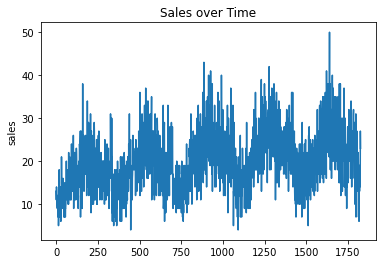

In [8]:
sns.lineplot(x=data.index, y=data["sales"]).set_title("Sales over Time")
plt.show()

### Distinguish Trend and Seasonality

<Figure size 432x288 with 0 Axes>

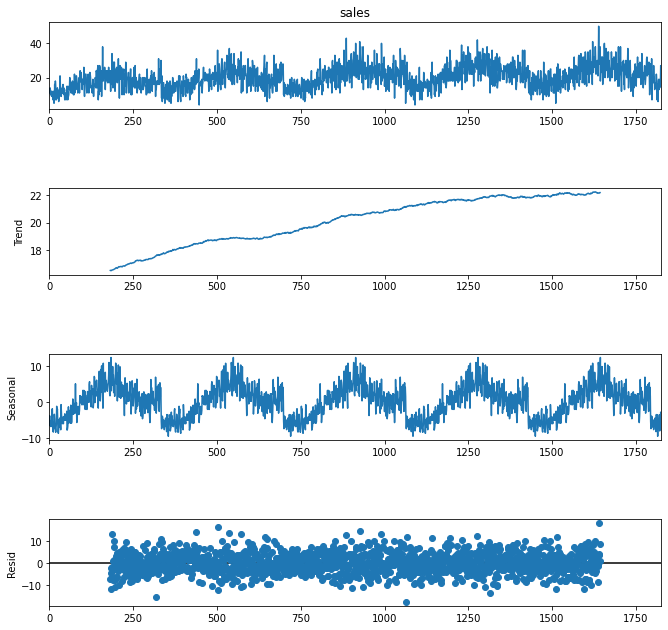

In [9]:
result = seasonal_decompose(data["sales"], period=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 10)
plt.show()

From the charts above it is clear that there is an increasing trend and a seasonality where the Summer months have higher sales. Due to the upwards trend, the data is <Strong>Non-Stationary</Strong>. Non-Stationary data refers to the time series data that mean and variance vary across time.

### Dickey-Fuller Test

In [10]:
def dickey_fuller_test(data):
    print('Dickey-Fuller Test:')
    testResult = adfuller(data)
    pValue = testResult[1]
    print("P-Value: " + str(pValue))

In [11]:
dickey_fuller_test(data["sales"])

Dickey-Fuller Test:
P-Value: 0.02256938062657181


P-value is greater than critical value of 1%, so the data is non-stationary. To improve on this, we can take first differences to make the data stationary.

In [12]:
data["sales_shifted"] = data["sales"] - data["sales"].shift(1)
data = data.dropna()

In [13]:
dickey_fuller_test(data["sales_shifted"])

Dickey-Fuller Test:
P-Value: 1.2109276320434391e-23


P-value is less than 1% now, therefore we can reject the null hypothesis and say the data is now stationary.

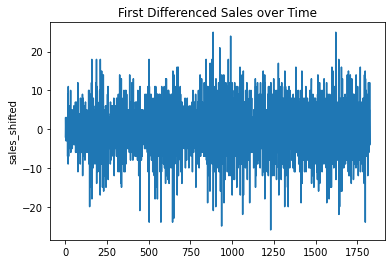

In [14]:
sns.lineplot(x=data.index, y=data["sales_shifted"]).set_title("First Differenced Sales over Time")
plt.show()

# Finding ARIMA Parameters

Intuitively, ARIMA models compose 3 parts: the autoregressive term (AR) and the moving-average term (MA). The former views the value at one time just as a weighted sum of past values. The latter model that same value also as a weighted sum but of past residuals

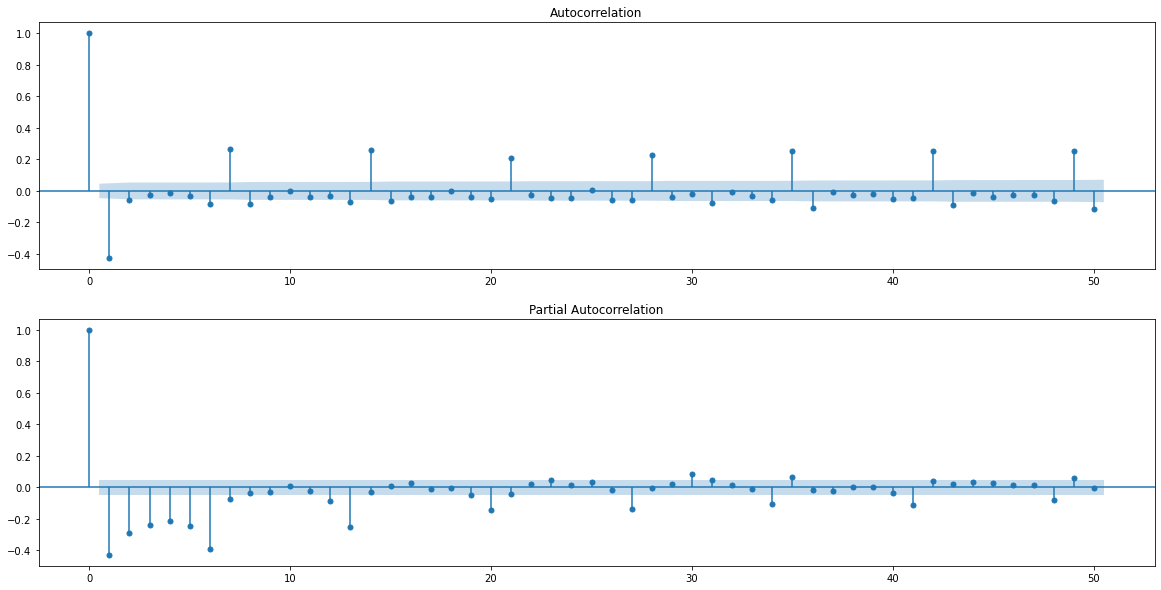

In [15]:
#Autocorrelation for First Differenced Sales
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(data["sales_shifted"], lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data["sales_shifted"], lags=50, ax=ax[1])
plt.show()

# Modelling

In [16]:
start_index = 1730
end_index = 1826

### ARIMA

In [17]:
arima = sm.tsa.ARIMA(data.sales[:start_index], (6,1,1)).fit(disp=False)
print(arima.summary())

C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1729
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5296.072
Method:                       css-mle   S.D. of innovations              5.173
Date:                Wed, 13 Apr 2022   AIC                          10610.145
Time:                        10:27:43   BIC                          10659.242
Sample:                             1   HQIC                         10628.305
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0071      0.023      0.310      0.756      -0.038       0.052
ar.L1.D.sales    -0.6024      0.063     -9.594      0.000      -0.725      -0.479
ar.L2.D.sales    -0.6023      0.050    -

C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:>

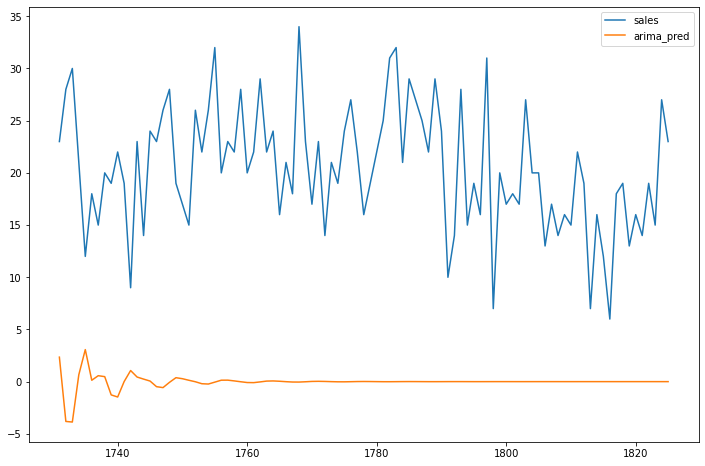

In [18]:
data["arima_pred"] = arima.predict(start = start_index, end= end_index, dynamic= True)  
data[start_index:end_index][['sales', 'arima_pred']].plot(figsize=(12, 8))

In [19]:
def evaluate(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    rmse = mean_squared_error(y_true, y_pred, squared=True)
    print('MAPE: %.2f %% \nSMAPE: %.2f %% \nRMSE: %.2f'% (mape,smape,rmse), "%")

In [20]:
evaluate(data[1730:1826]['sales'],data[1730:1826]['arima_pred'])

MAPE: 99.74 % 
SMAPE: 197.30 % 
RMSE: 455.86 %


### SARIMA

In [21]:
sarima = sm.tsa.statespace.SARIMAX(data["sales"], order=(6,1,1)).fit()
print(sarima.summary())

C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1825
Model:               SARIMAX(6, 1, 1)   Log Likelihood               -5589.434
Date:                Wed, 13 Apr 2022   AIC                          11194.869
Time:                        10:27:45   BIC                          11238.939
Sample:                             0   HQIC                         11211.126
                               - 1825                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6343      0.050    -12.725      0.000      -0.732      -0.537
ar.L2         -0.6174      0.039    -15.629      0.000      -0.695      -0.540
ar.L3         -0.5796      0.036    -16.015      0.0

C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:>

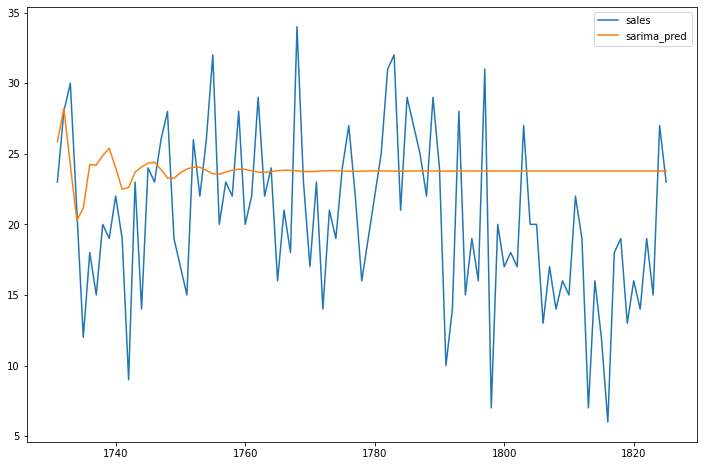

In [22]:
start_index = 1730
end_index = 1826
data['sarima_pred'] = sarima.predict(start = start_index, end=  end_index, dynamic = True)  
data[start_index:end_index][['sales', 'sarima_pred']].plot(figsize=(12, 8))

In [23]:
evaluate(data[1730:1826]['sales'],data[1730:1826]['sarima_pred'])

MAPE: 36.90 % 
SMAPE: 27.04 % 
RMSE: 44.91 %


# Holidays

In [24]:
data = data.drop(columns=['arima_pred', 'sarima_pred'])

In [25]:
holiday = pd.read_csv('data/USHolidays.csv', usecols = ["Date", "Holiday"])
holiday['Date'] = pd.to_datetime(holiday['Date'], yearfirst = True, infer_datetime_format=True)
holiday.head()

,Date,Holiday
0,2004-07-04,4th of July
1,2005-07-04,4th of July
2,2006-07-04,4th of July
3,2007-07-04,4th of July
4,2008-07-04,4th of July


In [26]:
holiday = holiday[holiday["Date"].dt.year == 2013]
holiday.columns = ["date", "holiday"]

In [27]:
holiday

,date,holiday
9,2013-07-04,4th of July
27,2013-12-25,Christmas Day
45,2013-12-24,Christmas Eve
70,2013-10-14,Columbus Day
89,2013-05-05,Eastern Easter
101,2013-06-19,Juneteenth
110,2013-09-02,Labor Day
130,2013-08-31,Labor Day Weekend
132,2013-09-01,Labor Day Weekend
178,2013-01-21,"Martin Luther King, Jr. Day"


In [28]:
data = data.merge(holiday, how='left', on='date')
data['holiday_bool'] = pd.notnull(data['holiday']).astype(int)
data = pd.get_dummies(data, columns = ['month','holiday','weekday'] , prefix = ['month','holiday','weekday'])

In [29]:
data.head()

,date,item,sales,store,year,day,sales_shifted,holiday_bool,month_1,month_2,...,holiday_Veterans Day,holiday_Washington's Birthday,holiday_Western Easter,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-02,1,11.0,1,2013,2,-2.0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2013-01-03,1,14.0,1,2013,3,3.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,2013-01-04,1,13.0,1,2013,4,-1.0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,2013-01-05,1,10.0,1,2013,5,-3.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,2013-01-06,1,12.0,1,2013,6,2.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
data = data.set_index('date')

In [31]:
data.head()

,item,sales,store,year,day,sales_shifted,holiday_bool,month_1,month_2,month_3,...,holiday_Veterans Day,holiday_Washington's Birthday,holiday_Western Easter,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,1,11.0,1,2013,2,-2.0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,14.0,1,2013,3,3.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,13.0,1,2013,4,-1.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,10.0,1,2013,5,-3.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2013-01-06,1,12.0,1,2013,6,2.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
sarima_holidays = sm.tsa.statespace.SARIMAX(endog = data.sales[:1731],
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarima_holidays.summary())

C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1731
Model:             SARIMAX(6, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -5150.443
Date:                             Wed, 13 Apr 2022   AIC                          10316.887
Time:                                     10:27:49   BIC                          10360.501
Sample:                                 01-02-2013   HQIC                         10333.022
                                      - 09-28-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8256      0.024    -35.119      0.000      -0.872      -0.779
ar.L2         -0.7137      

C:\Users\rajpa\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2292: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


<AxesSubplot:xlabel='date'>

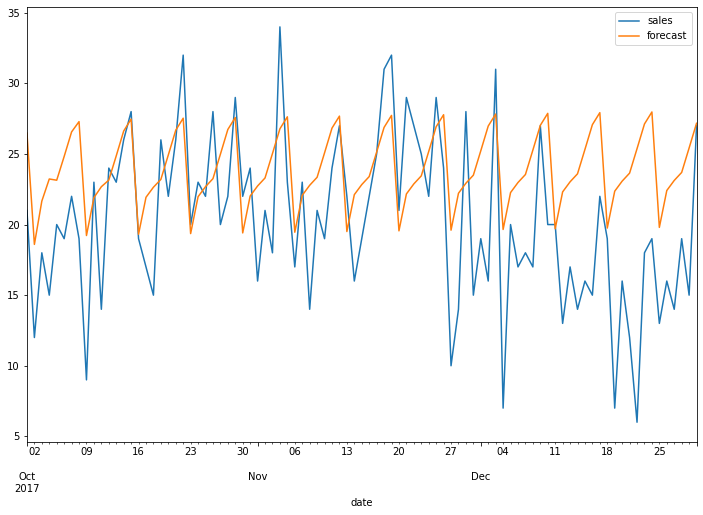

In [33]:
start_index = '2017-10-01'
end_index = '2017-12-30'
data['forecast'] = sarima_holidays.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index),
                                            #exog = exog_data[start_index:end_index], 
                                            dynamic= True)  

data[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [34]:
evaluate(data[start_index:end_index]['sales'],data[start_index:end_index]['forecast'])

MAPE: 35.35 % 
SMAPE: 26.02 % 
RMSE: 40.81 %
